# COMP5318 - Machine Learning and Data Mining: Assignment 1
## Classifier 1: Deep Neural Network
## Classifier 2: Convolutional Neural Network

<div style="text-align: right">Nhu Dung TO (460435636 | duto3894@uni.sydney.edu.au)</div>
<div style="text-align: right">Zhezhou CHEN (490564752 | zche0836@uni.sydney.edu.au)</div>

# Summary
The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

### 1.1 Load the data
There is a data folder with 4 main files (which can be downloaded from Canvas):
    1. images_training.h5
    2. labels_training.h5
    3. images_testing.h5
    4. labels_testing_2000.h5

To read the hdf5 file and load the data into a numpy array, assuming the **training data files are in the ./data/train** and **testing data file are in ./data/test**. <br /> Use the following code:

Then data would be a numpy array of the shape (30000, 784), and
label would be a numpy array of the shape (30000, ).
The file images_testing.h5 can be loaded in a similar way.

In [65]:
import h5py
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt
print(os.listdir("./Input/train"))
np.random.seed(1)

['images_training.h5', 'labels_training.h5']


In [28]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
with h5py.File('./Input/test/images_testing.h5', 'r') as H:
    data_test = np.copy(H['datatest'])
    
with h5py.File('./Input/test/labels_testing_2000.h5') as H:
    label_test = np.copy(H['labeltest'])
    
print(data_train.shape, label_train.shape)
print(data_test.shape, label_test.shape)

(30000, 784) (30000,)
(10000, 784) (2000,)


Showing a sample data. The first example belongs to class 0: T-Shirt/Top

### 1.2 Data Preprocessing

In [29]:
data_train -= np.mean(data_train, axis=1, keepdims=True)
data_test -= np.mean(data_test, axis=1, keepdims=True)

## 2. Classifier 1: Deep Neural Network Classifier

### 2.1 Initialize weight matrices

To initialize weight matrices, we use He initialization according to He et al., 2015 which is the recommended method to use with ReLU activation. Basically, He initialization initializes weight matrices and multiply with a scaling factor of $\sqrt{\frac{2}{n}}$ where n is the number of neurons of the previous layers.

In [30]:
def initialize_parameters_he(layer_dims):    
    parameters = {}
    L = len(layer_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2.0 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

In [31]:
parameters = initialize_parameters_he([784, 50, 50, 10])
parameters['W1'].shape

(50, 784)

### 2.2 Activation function
As mentioned, we use ReLU function as the activation function for each neuron

In [32]:
def relu(x):
    return np.maximum(0, x)

In [33]:
### 2.3 Represent labels as one-hot vectors

In [34]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [35]:
convert_to_one_hot(np.array([3, 4, 2, 0]), 5)

array([[0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [36]:
def softmax(Y):
    denominator = np.sum(np.exp(Y), axis=0)
    return np.exp(Y) / denominator[None, :] 

In [37]:
arr = np.array([[1, 3, 4], [2, 3, 3], [7, 4, 3]])
arr

array([[1, 3, 4],
       [2, 3, 3],
       [7, 4, 3]])

In [38]:
softmax(arr)

array([[0.00245611, 0.21194156, 0.57611688],
       [0.00667641, 0.21194156, 0.21194156],
       [0.99086747, 0.57611688, 0.21194156]])

### 2.2 Forward propagation

In [39]:
def forward(X, parameters):
    
    L = len(parameters) // 2 
    forward_outputs = {
        "a0":X
    }
    
    for l in range(L):
        forward_outputs["z"+str(l+1)] = np.dot(parameters["W"+str(l+1)], forward_outputs["a"+str(l)]) + parameters["b"+str(l+1)]
        if l != L - 1:
            forward_outputs["a"+str(l+1)] = relu(forward_outputs["z"+str(l+1)])
        else:
            forward_outputs["a"+str(l+1)] = softmax(forward_outputs["z"+str(l+1)])
    
    return forward_outputs

### 2.3 Backward propagation

In [40]:
def backward(X, Y, forward_outputs, parameters):
    m = X.shape[1] # number of training examples
    L = len(parameters) // 2
    
    grads = {}
    
    for l in range(L-1, -1, -1):
        if l == L-1:
            grads["dz"+str(l+1)] = 1./m * (forward_outputs["a"+str(l+1)] - Y)
        else:
            grads["da"+str(l+1)] = np.dot((parameters["W"+str(l+2)]).T, grads["dz"+str(l+2)])
            grads["dz"+str(l+1)] = np.multiply(grads["da"+str(l+1)], np.int64(forward_outputs["a"+str(l+1)] > 0))
        grads["dW"+str(l+1)] = np.dot(grads["dz"+str(l+1)], (forward_outputs["a"+str(l)]).T)
        grads["db"+str(l+1)] = np.sum(grads["dz"+str(l+1)], axis=1, keepdims=True)
    
    return grads

### 2.4 Gradient Descent Optimizer

In [41]:
def update_parameters_with_gradient_descent(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

### 2.5 Adam optimizer

In [42]:
def initialize_adam(parameters) :

    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s

In [43]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.001,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    
    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1) * grads["db" + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1- np.power(beta1, t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1- np.power(beta1, t))

        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * np.square(grads["dW" + str(l+1)])
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * np.square(grads["db" + str(l+1)])
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - np.power(beta2, t))
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * (v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * (v_corrected["db" + str(l+1)] / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon))
        
    return parameters, v, s

### 2.7 Compute cost function

In [44]:
def compute_cost(Y_hat, Y):
    m = Y.shape[1]
    return 1./m * - np.sum(np.multiply(Y, np.log(Y_hat)))

### 2.7 Extract mini batches

In [45]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
  
    np.random.seed(seed)            
    m = X.shape[1]                  
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 2.8 Model with gradient descent optimizer

In [46]:
def train_with_gradient_descent_optimizer(X, Y, learning_rate=0.01, num_epochs=50, mini_batch_size=64):
    costs = []
    
    parameters = initialize_parameters_he([784, 200, 150, 50, 10])
    
    L = len(parameters) // 2
    
    for i in range(1, num_epochs + 1):
        
        seed = 0

        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:
            
            (minibatch_X, minibatch_Y) = minibatch
            
            forward_outputs = forward(minibatch_X, parameters)
        
            Y_hat = forward_outputs["a" + str(L)]
            
            cost = compute_cost(Y_hat, minibatch_Y)
            
            grads = backward(minibatch_X, minibatch_Y, forward_outputs, parameters)
        
            update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        costs.append(cost)
    return costs, parameters

### 2.9 Model with Adam optimizer

In [47]:
def train_with_adam_optimizer(X, Y, learning_rate=0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_epochs=30, mini_batch_size=32):
    costs = []
    
    parameters = initialize_parameters_he([784, 200, 150, 50, 10])
    
    v, s = initialize_adam(parameters)
    
    t = 0  
    
    L = len(parameters) // 2
    
    seed = 0
    
    for i in range(1, num_epochs + 1):
        
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:
            
            (minibatch_X, minibatch_Y) = minibatch
            
            forward_outputs = forward(minibatch_X, parameters)
            
            Y_hat = forward_outputs["a" + str(L)]
            
            cost = compute_cost(Y_hat, minibatch_Y)
            
            grads = backward(minibatch_X, minibatch_Y, forward_outputs, parameters)
        
            t = t + 1 # Adam counter
        
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
        costs.append(cost)
    return costs, parameters

### 2.10 Predict function

In [48]:
def predict(X, parameters):
    L = len(parameters) // 2
    forward_outputs = forward(X, parameters)
    Y_hat = forward_outputs["a" + str(L)]
    return Y_hat, np.argmax(Y_hat, axis=0)

### 2.11 Training

In [49]:
X_train = data_train.T
Y_train = convert_to_one_hot(label_train.T, 10)
X_test  = data_test[0:2000,:].T
X_test_5000  = data_test[0:5000,:].T

Y_test  = convert_to_one_hot(label_test.T, 10)

mini_batches_folds = random_mini_batches(X_train, Y_train, mini_batch_size = 24000, seed = 0)
(Xtrain, Ytrain) = mini_batches_folds[0]
(Xval, Yval) = mini_batches_folds[1]

#### 2.11.1 Training with gradient descent

In [50]:
start_time = time.time()
costs, parameters_gd = train_with_gradient_descent_optimizer(Xtrain, Ytrain)
elapsed_time = time.time() - start_time
print("Elapsed time: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Elapsed time: 00:01:20


In [51]:
_, predictions_train = predict(Xtrain, parameters_gd)
_, predictions_val = predict(Xval, parameters_gd)
_, predictions_test = predict(X_test, parameters_gd)
_, predictions_test_5000 = predict(X_test_5000, parameters_gd)

In [52]:
print('Training accuracy with Gradient Descent = ' + str(np.sum(predictions_train == np.argmax(Ytrain, axis=0)) / Ytrain.shape[1] * 100) + '%')
print('Validation accuracy with Gradient Descent = ' + str(np.sum(predictions_val == np.argmax(Yval, axis=0)) / Yval.shape[1] * 100) + '%')
print('Test accuracy with Gradient Descent = ' + str(np.sum(predictions_test == label_test) / label_test.shape[0] * 100) + '%')

Training accuracy with Gradient Descent = 93.0125%
Validation accuracy with Gradient Descent = 86.81666666666666%
Test accuracy with Gradient Descent = 85.55%


In [53]:
with h5py.File('Output/predicted_labels_classifer_1_gd.h5','w') as H:
    H.create_dataset('output',data=predictions_test_5000)

In [54]:
predictions_test_5000.shape

(5000,)

#### 2.11.2 Training with Adam optimizer

In [55]:
start_time = time.time()
costs, parameters_adam = train_with_adam_optimizer(Xtrain, Ytrain)
elapsed_time = time.time() - start_time
print("Elapsed time: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Elapsed time: 00:04:28


In [56]:
_, predictions_train = predict(Xtrain, parameters_adam)
_, predictions_val = predict(Xval, parameters_adam)
_, predictions_test = predict(X_test, parameters_adam)
_, predictions_test_5000 = predict(X_test_5000, parameters_adam)

In [57]:
print('Training accuracy with Adam optimizer = ' + str(np.sum(predictions_train == np.argmax(Ytrain, axis=0)) / Ytrain.shape[1] * 100) + '%')
print('Validation accuracy with Adam optimizer = ' + str(np.sum(predictions_val == np.argmax(Yval, axis=0)) / Yval.shape[1] * 100) + '%')
print('Test accuracy with Adam optimizer = ' + str(np.sum(predictions_test == label_test) / label_test.shape[0] * 100) + '%')

Training accuracy with Adam optimizer = 96.70833333333333%
Validation accuracy with Adam optimizer = 87.83333333333333%
Test accuracy with Adam optimizer = 87.05000000000001%


In [58]:
with h5py.File('Output/predicted_labels.h5','w') as H:
    H.create_dataset('output',data=predictions_test_5000)

In [59]:
with h5py.File('./Output/predicted_labels.h5','r') as H:
    output = np.copy(H['output'])
output.shape

(5000,)

### 2.12 Hyper parameters tuning

#### 2.12.1 Learning rates

##### Different learning rates with gradient descent

In [60]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]

In [61]:
gd_learning_rate_results =  {}
for lr in learning_rates:
    costs, parameters = train_with_gradient_descent_optimizer(Xtrain, Ytrain, learning_rate=lr)
    
    Y_hat_train, predictions_train = predict(Xtrain, parameters)
    accuracy_train = np.sum(predictions_train == np.argmax(Ytrain, axis=0)) / Ytrain.shape[1] * 100
    
    Y_hat_val, predictions_val = predict(Xval, parameters)
    accuracy_val = np.sum(predictions_val == np.argmax(Yval, axis=0)) / Yval.shape[1] * 100
    
    Y_hat_test, predictions_test = predict(X_test, parameters)
    accuracy_test = np.sum(predictions_test == label_test) / label_test.shape[0] * 100
    
    gd_learning_rate_results[lr] = {
        'costs': costs,
        'parameters': parameters,
        'accuracy_train': accuracy_train,
        'accuracy_val': accuracy_val,
        'accuracy_test': accuracy_test
    }

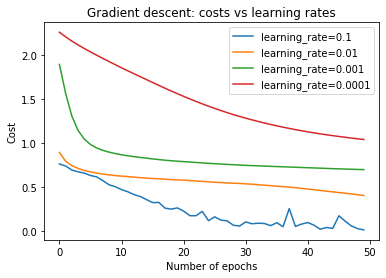

In [62]:
plt.plot(gd_learning_rate_results[0.1]['costs'], label="learning_rate=0.1")
plt.plot(gd_learning_rate_results[0.01]['costs'], label="learning_rate=0.01")
plt.plot(gd_learning_rate_results[0.001]['costs'], label="learning_rate=0.001")
plt.plot(gd_learning_rate_results[0.0001]['costs'], label="learning_rate=0.0001")
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Cost')
plt.title('Gradient descent: costs vs learning rates')
plt.savefig('figures/gd-search-learning-rates-costs.pdf')
plt.show()

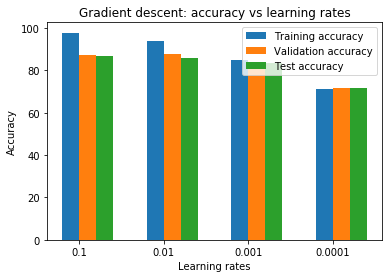

In [63]:
N = 4
gd1 = gd_learning_rate_results[0.1]
gd01 = gd_learning_rate_results[0.01]
gd001 = gd_learning_rate_results[0.001]
gd0001 = gd_learning_rate_results[0.0001]

accuracy_train = (gd1['accuracy_train'], gd01['accuracy_train'], gd001['accuracy_train'], gd0001['accuracy_train'])
accuracy_val = (gd1['accuracy_val'], gd01['accuracy_val'], gd001['accuracy_val'], gd0001['accuracy_val'])
accuracy_test = (gd1['accuracy_test'], gd01['accuracy_test'], gd001['accuracy_test'], gd0001['accuracy_test'])

ind = np.arange(N) 
width = 0.2       
plt.bar(ind, accuracy_train, width, label='Training accuracy')
plt.bar(ind + width, accuracy_val, width, label='Validation accuracy')
plt.bar(ind + 2*width, accuracy_test, width, label='Test accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Learning rates')
plt.title('Gradient descent: accuracy vs learning rates')

plt.xticks(ind + width / 2, ('0.1', '0.01', '0.001', '0.0001'))
plt.legend(loc='best')
plt.savefig('figures/gd-search-learning-rates-accuracy.pdf')
plt.show()

##### Different learning rates with Adam optimizer

In [64]:
adam_learning_rate_results = {}
for lr in learning_rates:
    costs, parameters = train_with_adam_optimizer(Xtrain, Ytrain, learning_rate=lr)
    
    Y_hat_train, predictions_train = predict(Xtrain, parameters)
    accuracy_train = np.sum(predictions_train == np.argmax(Ytrain, axis=0)) / Ytrain.shape[1] * 100
    
    Y_hat_val, predictions_val = predict(Xval, parameters)
    accuracy_val = np.sum(predictions_val == np.argmax(Yval, axis=0)) / Yval.shape[1] * 100
    
    Y_hat_test, predictions_test = predict(X_test, parameters)
    accuracy_test = np.sum(predictions_test == label_test) / label_test.shape[0] * 100
    
    adam_learning_rate_results[lr] = {
        'costs': costs,
        'parameters': parameters,
        'accuracy_train': accuracy_train,
        'accuracy_val': accuracy_val,
        'accuracy_test': accuracy_test
    }

C:\Users\alext\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alext\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alext\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alext\Miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


KeyboardInterrupt: 

In [208]:
for lr in learning_rates:
    parameters = adam_learning_rate_results[lr]['parameters']
    
    Y_hat_train, predictions_train = predict(Xtrain, parameters)
    accuracy_train = np.sum(predictions_train == np.argmax(Ytrain, axis=0)) / Ytrain.shape[1] * 100
    
    Y_hat_val, predictions_val = predict(Xval, parameters)
    accuracy_val = np.sum(predictions_val == np.argmax(Yval, axis=0)) / Yval.shape[1] * 100
    
    Y_hat_test, predictions_test = predict(X_test, parameters)
    accuracy_test = np.sum(predictions_test == label_test) / label_test.shape[0] * 100
    
    adam_learning_rate_results[lr]['accuracy_train'] = accuracy_train
    adam_learning_rate_results[lr]['accuracy_val'] = accuracy_val
    adam_learning_rate_results[lr]['accuracy_test'] = accuracy_test

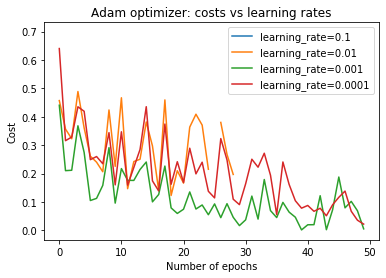

In [209]:
plt.plot(adam_learning_rate_results[0.1]['costs'], label="learning_rate=0.1")
plt.plot(adam_learning_rate_results[0.01]['costs'], label="learning_rate=0.01")
plt.plot(adam_learning_rate_results[0.001]['costs'], label="learning_rate=0.001")
plt.plot(adam_learning_rate_results[0.0001]['costs'], label="learning_rate=0.0001")

plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Cost')
plt.title('Adam optimizer: costs vs learning rates')
plt.savefig('figures/adam-search-learning-rates-costs.pdf')
plt.show()

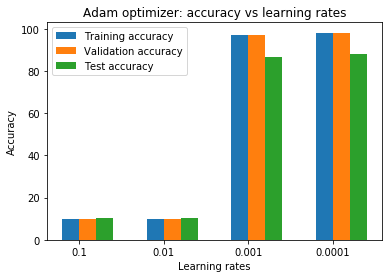

In [210]:
N = 4
ad1 = adam_learning_rate_results[0.1]
ad01 = adam_learning_rate_results[0.01]
ad001 = adam_learning_rate_results[0.001]
ad0001 = adam_learning_rate_results[0.0001]

accuracy_train = (ad1['accuracy_train'], ad01['accuracy_train'], ad001['accuracy_train'], ad0001['accuracy_train'])
accuracy_val = (ad1['accuracy_val'], ad01['accuracy_val'], ad001['accuracy_val'], ad0001['accuracy_val'])
accuracy_test = (ad1['accuracy_test'], ad01['accuracy_test'], ad001['accuracy_test'], ad0001['accuracy_test'])

ind = np.arange(N) 
width = 0.2       
plt.bar(ind, accuracy_train, width, label='Training accuracy')
plt.bar(ind + width, accuracy_val, width, label='Validation accuracy')
plt.bar(ind + 2*width, accuracy_test, width, label='Test accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Learning rates')
plt.title('Adam optimizer: accuracy vs learning rates')

plt.xticks(ind + width / 2, ('0.1', '0.01', '0.001', '0.0001'))
plt.legend(loc='best')
plt.savefig('figures/adam-search-learning-rates-accuracy.pdf')
plt.show()

#### 2.12.1 Mini batch size and number of epochs

In [28]:
mini_batch_sizes = [32, 64, 128]
number_of_epochs = [20, 30, 50, 100]

##### Different mini batch sizes and number of epochs with gradient descent

In [31]:
gd_mini_batch_epochs_results = {}

for m in mini_batch_sizes:
    for e in number_of_epochs:
        costs, parameters = train_with_gradient_descent_optimizer(Xtrain, Ytrain, learning_rate=0.01, mini_batch_size=m, num_epochs=e)
    
        Y_hat_train, predictions_train = predict(Xtrain, parameters)
        accuracy_train = np.sum(predictions_train == np.argmax(Ytrain, axis=0)) / Ytrain.shape[1] * 100

        Y_hat_val, predictions_val = predict(Xval, parameters)
        accuracy_val = np.sum(predictions_val == np.argmax(Yval, axis=0)) / Yval.shape[1] * 100

        Y_hat_test, predictions_test = predict(X_test, parameters)
        accuracy_test = np.sum(predictions_test == label_test) / label_test.shape[0] * 100

        gd_mini_batch_epochs_results[str(m)+"-"+str(e)] = {
            'costs': costs,
            'parameters': parameters,
            'accuracy_train': accuracy_train,
            'accuracy_val': accuracy_val,
            'accuracy_test': accuracy_test
        }

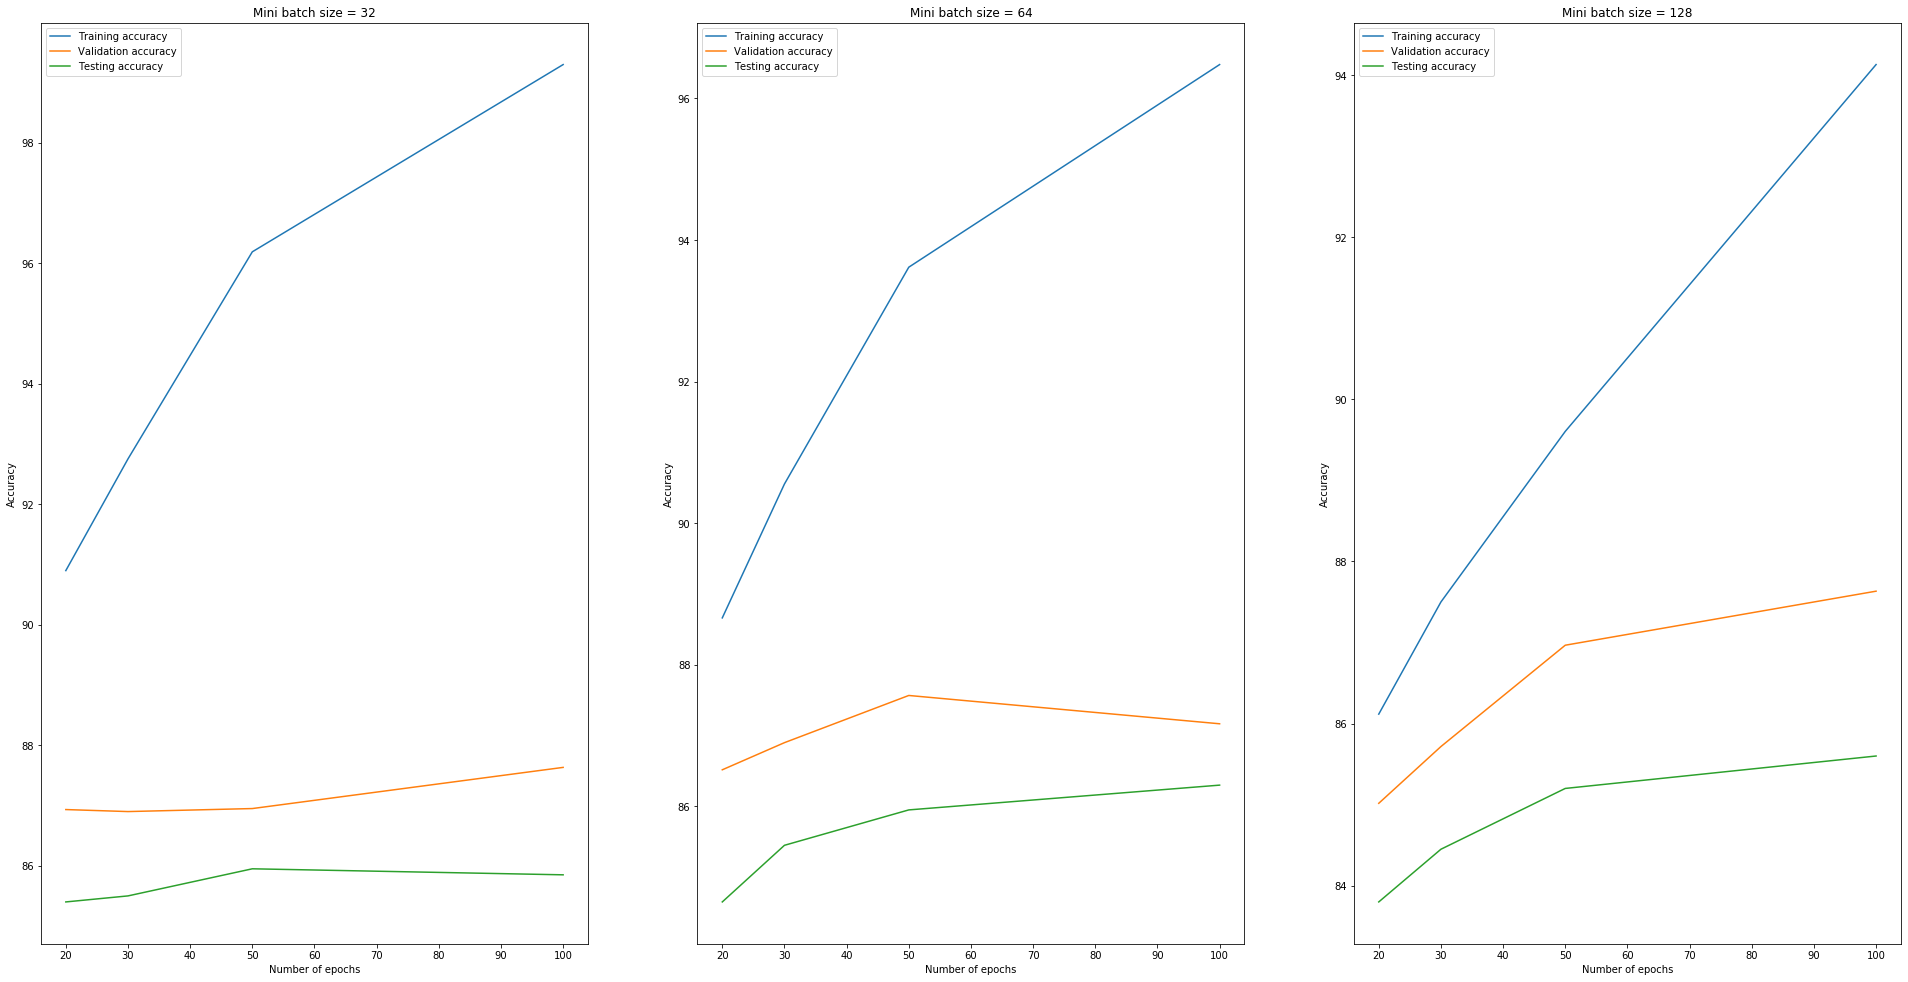

In [44]:
fig, axs = plt.subplots(1, 3)
DPI = fig.get_dpi()
fig.set_size_inches(2400.0/float(DPI),1220.0/float(DPI))

c = 0

for m in mini_batch_sizes:
    accuracy_train=[]
    accuracy_val=[]
    accuracy_test=[]
    for e in number_of_epochs:
        accuracy_train.append(gd_mini_batch_epochs_results[str(m)+"-"+str(e)]['accuracy_train'])
        accuracy_val.append(gd_mini_batch_epochs_results[str(m)+"-"+str(e)]['accuracy_val'])
        accuracy_test.append(gd_mini_batch_epochs_results[str(m)+"-"+str(e)]['accuracy_test'])
        
    axs[c].plot(number_of_epochs, accuracy_train, label="Training accuracy")
    axs[c].plot(number_of_epochs, accuracy_val, label="Validation accuracy")
    axs[c].plot(number_of_epochs, accuracy_test, label="Testing accuracy")
    axs[c].set_title('Mini batch size = ' + str(m))
    axs[c].set_xlabel('Number of epochs')
    axs[c].set_ylabel('Accuracy')
    axs[c].set_ylabel('Accuracy')
    axs[c].legend()
    c += 1
plt.savefig('figures/gd-search-batch-size.pdf')
plt.show()

In [54]:
adam_mini_batch_epochs_results = {}

for m in mini_batch_sizes:
    for e in number_of_epochs:
        costs, parameters = train_with_adam_optimizer(Xtrain, Ytrain, learning_rate=0.001, mini_batch_size=m, num_epochs=e)
    
        Y_hat_train, predictions_train = predict(Xtrain, parameters)
        accuracy_train = np.sum(predictions_train == np.argmax(Ytrain, axis=0)) / Ytrain.shape[1] * 100

        Y_hat_val, predictions_val = predict(Xval, parameters)
        accuracy_val = np.sum(predictions_val == np.argmax(Yval, axis=0)) / Yval.shape[1] * 100

        Y_hat_test, predictions_test = predict(X_test, parameters)
        accuracy_test = np.sum(predictions_test == label_test) / label_test.shape[0] * 100

        adam_mini_batch_epochs_results[str(m)+"-"+str(e)] = {
            'costs': costs,
            'parameters': parameters,
            'accuracy_train': accuracy_train,
            'accuracy_val': accuracy_val,
            'accuracy_test': accuracy_test
        }

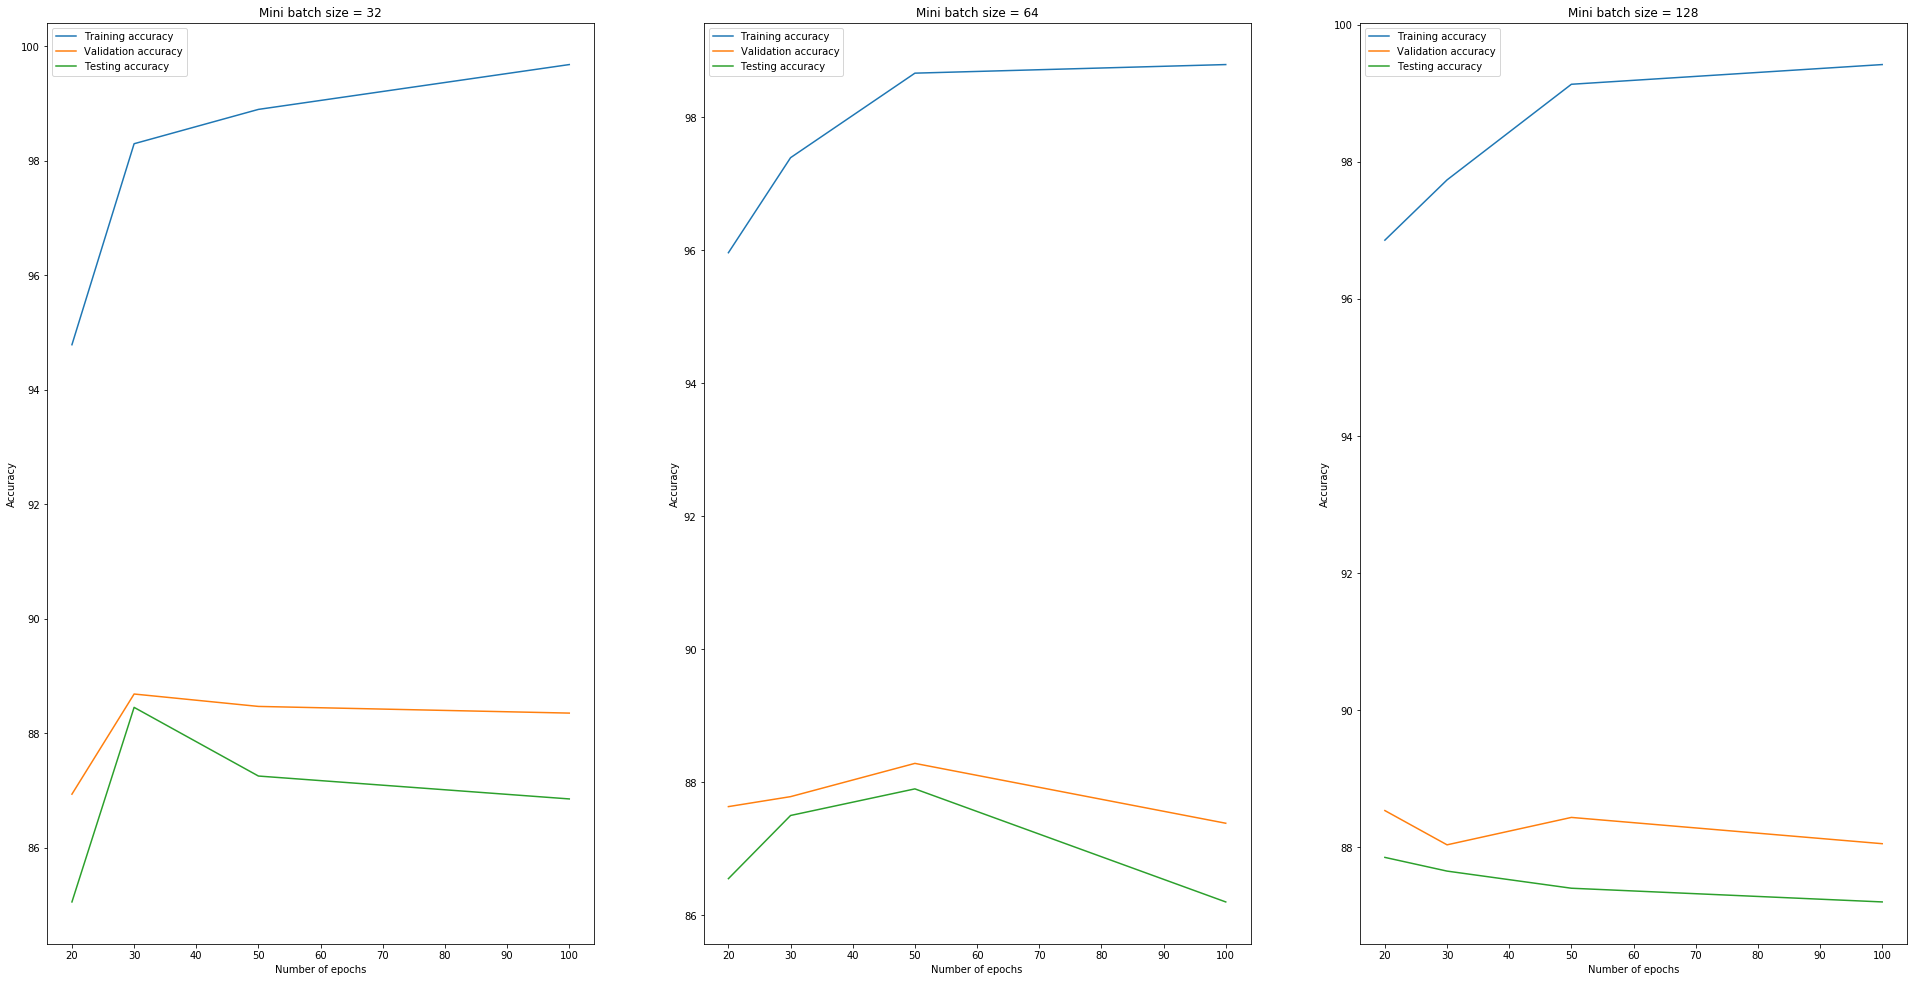

In [55]:
fig, axs = plt.subplots(1, 3)
DPI = fig.get_dpi()
fig.set_size_inches(2400.0/float(DPI),1220.0/float(DPI))

c = 0

for m in mini_batch_sizes:
    accuracy_train=[]
    accuracy_val=[]
    accuracy_test=[]
    for e in number_of_epochs:
        accuracy_train.append(adam_mini_batch_epochs_results[str(m)+"-"+str(e)]['accuracy_train'])
        accuracy_val.append(adam_mini_batch_epochs_results[str(m)+"-"+str(e)]['accuracy_val'])
        accuracy_test.append(adam_mini_batch_epochs_results[str(m)+"-"+str(e)]['accuracy_test'])
        
    axs[c].plot(number_of_epochs, accuracy_train, label="Training accuracy")
    axs[c].plot(number_of_epochs, accuracy_val, label="Validation accuracy")
    axs[c].plot(number_of_epochs, accuracy_test, label="Testing accuracy")
    axs[c].set_title('Mini batch size = ' + str(m))
    axs[c].set_xlabel('Number of epochs')
    axs[c].set_ylabel('Accuracy')
    axs[c].set_ylabel('Accuracy')
    axs[c].legend()
    c += 1
plt.savefig('figures/adam-search-batch-size.pdf')
plt.show()

(30000, 784) (30000,)
(10000, 784) (2000,)


## 3. Classifier 2: Convolutional Neural Network

In [92]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
with h5py.File('./Input/test/images_testing.h5', 'r') as H:
    data_test = np.copy(H['datatest'])
    
with h5py.File('./Input/test/labels_testing_2000.h5') as H:
    label_test = np.copy(H['labeltest'])
    
print(data_train.shape, label_train.shape)
print(data_test.shape, label_test.shape)

(30000, 784) (30000,)
(10000, 784) (2000,)


In [93]:
data_train -= np.mean(data_train, axis=1, keepdims=True)
data_test -= np.mean(data_test, axis=1, keepdims=True)

In [96]:
print(label_train.shape)

(30000,)


In [101]:
X_train = data_train.reshape((30000, 28, 28, 1))
X_test = data_test.reshape((10000, 28, 28, 1))[0:2000,:,:,:]
X_test_5000 = data_test.reshape((10000, 28, 28, 1))[0:5000,:,:,:]

Y_train = convert_to_one_hot(label_train, 10).T
Y_Test = convert_to_one_hot(label_test, 10).T

### 3.1 Padding
After each convo layer, the image size may shrink so we padd images with zeroes

In [102]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    return X_pad

### 3.2 Forward Propagation

#### 3.2.1 A single convo operation on a "matrix slice"

In [103]:
def convo_one_slice(a_slice, W, b):
    s = np.multiply(a_slice, W)
    z = np.sum(s) + np.float(b)
    return z

#### 3.2.2 Convo layer forward propagation

In [104]:
def relu(x):
    return np.maximum(0, x)

In [105]:
def softmax(Y):
    denominator = np.sum(np.exp(Y), axis=1)
    result = np.exp(Y) / denominator[:, None] 
    return result

In [106]:
def convo_forward(A_prev, W, b, hparams):
    
    # Get the height, width and number of channels from the previous layer
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get the filter size, number of channels from previous and current layer
    (f, f, n_C_prev, n_C) = W.shape

    # Get stride and padding hyper parameters
    stride = hparams["stride"]
    pad = hparams["pad"]
    
    # Calculate the current layer height and width
    n_H = int((n_H_prev + 2*pad - f) / stride + 1)
    n_W = int((n_W_prev + 2*pad - f) / stride + 1)
    
    Z = np.zeros((m, n_H, n_W, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    
    #for i in range(m):
    #a_prev_pad = A_prev_pad[i]
    
    for h in range(n_H):
        vert_start = h * stride
        vert_end = vert_start + f
        
        for w in range(n_W):
            #for c in range(n_C):
            
            horiz_start = w * stride
            horiz_end = horiz_start + f
            
            #a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start: horiz_end]
            #Z[i, h, w, c] = convo_one_slice(a_slice_prev, W[:,:,:,c], b[:,:,:,c].reshape(1))
            
            Z[:, h, w, :] = np.sum(A_prev_pad[:, 
                                                   vert_start:vert_end, 
                                                   horiz_start:horiz_end, :, 
                                                   np.newaxis] * 
                                     W[np.newaxis, :, :, :], axis=(1, 2, 3))

    Z = Z + b

    return Z

#### 3.2.3 Pooling layer forward propagation

In [107]:
def pool_forward(A_prev, hparameters, mode = "max"):
    f = hparameters['f']
    stride = hparameters['stride']
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    n_H = int((n_H_prev - f) / stride + 1)
    n_W = int((n_W_prev - f) / stride + 1)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    #for i in range(m):
    for h in range(n_H):
        vert_start = h * stride
        vert_end = vert_start + f    
        for w in range(n_W):
            #for c in range(n_C):
            horiz_start = w * stride
            horiz_end = horiz_start + f

            #a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
            
            a_prev_slice = A_prev[:, vert_start:vert_end, horiz_start:horiz_end, :]

            if mode == "max":
                A[:, h, w, :] = np.max(a_prev_slice, axis=(1, 2))

            elif mode == "average":
                A[:, h, w, :] = np.mean(a_prev_slice, axis=(1, 2))

    return A

In [108]:
def fc_forward(A_prev, W, b):
    return np.dot(A_prev, W) + b

In [109]:
def forward(X, hparameters, parameters):
    L = len(hparameters)
    
    forward_outputs = {}
    
    for l in range(L):
        layer = hparameters[l]
        if layer['type'] == 'input':
            forward_outputs[l] = {
                'A': X
            }
        if layer['type'] == 'convo':
            W = parameters[l]['W']
            b = parameters[l]['b']
            A_prev = forward_outputs[l-1]['A']            
            Z = convo_forward(A_prev, W, b, layer)
            A = relu(Z)
            forward_outputs[l] = {
                'A': A,
                'Z': Z
            }
        if layer['type'] == 'pool':
            A_prev = forward_outputs[l-1]['A']
            A = pool_forward(A_prev, layer, layer['mode'])
            forward_outputs[l] = {
                'A': A
            }
        if layer['type'] == 'fc':
            W = parameters[l]['W']
            b = parameters[l]['b']
            A_prev = forward_outputs[l-1]['A']
            layer_prev = hparameters[l-1]
            if layer_prev['type'] == 'fc':
                Z = fc_forward(A_prev, W, b)
                A = relu(Z)
                forward_outputs[l] = {
                    'Z': Z,
                    'A': A
                }
            if layer_prev['type'] == 'pool':
                Z = fc_forward(A_prev.reshape((A_prev.shape[0], -1)), W, b)
                A = relu(Z)
                forward_outputs[l] = {
                    'Z': Z,
                    'A': A
                }
        if layer['type'] == 'softmax':
            W = parameters[l]['W']
            b = parameters[l]['b']
            A_prev = forward_outputs[l-1]['A']
            Z = fc_forward(A_prev, W, b)
            A = softmax(Z)
            forward_outputs[l] = {
                'Z': Z,
                'A': A
            }
    return forward_outputs

### 3.3 Backward propagation:

#### 3.3.1 Convo layer backward propagation

In [110]:
def convo_backward(dA, A, A_prev, parameters, hparameters):

    W = parameters['W']
    b = parameters['b']
      
    dZ = np.multiply(dA, np.int64(A > 0))
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros(A_prev.shape)    
    
    dW = np.zeros(W.shape)
    
    db = 1 / m * dZ.sum(axis=(0, 1, 2))

    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    #for i in range(m):                       
        
    #a_prev_pad = A_prev_pad[i, :, :, :]
    #da_prev_pad = dA_prev_pad[i, :, :, :]

    for h in range(n_H):     
        vert_start = h * stride
        vert_end = vert_start + f
        
        for w in range(n_W):               
            #for c in range(n_C):       
               
            horiz_start = w * stride
            horiz_end = horiz_start + f

            #a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

            #da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
            
            #dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
            #db[:,:,:,c] += dZ[i, h, w, c]
            
            dA_prev_pad[:, vert_start:vert_end, horiz_start:horiz_end, :] += \
                    np.sum(W[np.newaxis, :, :, :, :] * dZ[:, h:h+1, w:w+1, np.newaxis, :], axis=4)

            dW += np.sum(A_prev_pad[:, vert_start:vert_end, horiz_start:horiz_end, :, np.newaxis] *
                         dZ[:, h:h+1, w:w+1, np.newaxis, :], axis=0)

    dW /= m

    dA_prev = dA_prev_pad[:, pad:-pad, pad:-pad, :]
    
    return dA_prev, dZ, dW, db

#### 3.3.2 Pooling layer backward propagation

In [111]:
def create_max_mask(X):
        mask = np.zeros_like(x)
        x2 = x.reshape(x.shape[0], x.shape[1] * x.shape[2], x.shape[3])
        idx = np.argmax(x2, axis=1)

        ax1, ax2 = np.indices((x.shape[0], x.shape[3]))
        mask.reshape(mask.shape[0], mask.shape[1] * mask.shape[2], mask.shape[3])[ax1, idx, ax2] = 1
        return mask 

In [112]:
def distribute_value(x, shape):
    (h, w) = shape
    return np.ones(shape) * x / (h * w)

In [113]:
def pool_backward(dA, A_prev, hparameters):
        
    stride = hparameters['stride']
    f = hparameters['f']
    n_W = hparameters['n_W']
    n_H = hparameters['n_H']
    n_C = hparameters['n_C']
    mode = hparameters['mode']
    
    m = dA.shape[0]
    
    dA = dA.reshape(m, n_H, n_W, n_C)
    
    dA_prev = np.zeros(A_prev.shape)
       
    #for i in range(m):
        
        #a_prev = A_prev[i, :, :, :]
        
    for h in range(n_H):
        vert_start = h * stride
        vert_end = vert_start + f
        
        for w in range(n_W):               
            #for c in range(n_C):           
            
            horiz_start = w * stride
            horiz_end = horiz_start + f

            if mode == "max":

                mask = create_max_mask(A_prev[:, vert_start:vert_end, horiz_start:horiz_end, :])
                dA_prev[:, vert_start:vert_end, horiz_start:horiz_end, :] += dA[:, h:h+1, w:w+1, :] * mask

            elif mode == "average":

                mean = np.copy(dA[:, h:h+1, w:w+1, :])
                mean[:, :, :, np.arange(mean.shape[-1])] /= (f * f)
                dA_prev[:, vert_start:vert_end, horiz_start:horiz_end, :] += mean
   
                        
    return dA_prev         

In [114]:
def fc_backward(dA, A, A_prev, parameters):
    W = parameters['W']
    b = parameters['b']
    dZ = np.multiply(dA, np.int64(A > 0))
    dW = np.dot(A_prev.T, dZ)
    
    dW = dW.reshape(W.shape) # dW shape calculated from the dot product of A_prev and 
                             # dZ maybe different from W if previous layer is pooling.
    
    db = np.sum(dZ, axis=0, keepdims=True)
    dA_prev = np.dot(dZ, W.T)
 
    return dA_prev, dZ, dW, db

In [115]:
def softmax_backward(Y, A, A_prev, parameters):
    m = Y.shape[0]
    W = parameters['W']
    
    dZ = 1./m * (A - Y)
    dW = np.dot(A_prev.T, dZ)
    db = np.sum(dZ, axis=0, keepdims=True)
    dA_prev = np.dot(dZ, W.T)
    return dA_prev, dZ, dW, db

In [116]:
def backward(X, Y, forward_outputs, hparameters, parameters):
    L = len(hparameters)
    
    grads = {}
    
    for l in range(L-1, -1, -1):
        layer_parameters = parameters[l]
        layer = hparameters[l]
        A = forward_outputs[l]['A']
        
        if layer['type'] == 'softmax':
            A_prev = forward_outputs[l-1]['A']
            dA_prev, dZ, dW, db = softmax_backward(Y, A, A_prev, layer_parameters)
            grads[l] = {
                'dZ': dZ,
                'dW': dW,
                'db': db
            }
            grads[l-1] = {
                'dA': dA_prev
            }
        if layer['type'] == 'fc':
            dA = grads[l]['dA']
            A_prev = forward_outputs[l-1]['A']
            dA_prev, dZ, dW, db = fc_backward(dA, A, A_prev, layer_parameters)
            grads[l] = {
                'dZ': dZ,
                'dA': dA,
                'dW': dW,
                'db': db
            }
            grads[l-1] = {
                'dA': dA_prev
            }
        if layer['type'] == 'pool':
            dA = grads[l]['dA']
            A_prev = forward_outputs[l-1]['A']
            dA_prev = pool_backward(dA, A_prev, layer)
            grads[l-1] = {
                'dA': dA_prev
            }
        if layer['type'] == 'convo':
            dA = grads[l]['dA']
            A_prev = forward_outputs[l-1]['A']
            dA_prev, dZ, dW, db = convo_backward(dA, A, A_prev, layer_parameters, layer)
            grads[l] = {
                'dZ': dZ,
                'dA': dA,
                'dW': dW,
                'db': db
            }
            grads[l-1] = {
                'dA': dA_prev
            }
    return grads

### 3.4 Model

In [117]:
def update_parameters_with_adam(hparameters, parameters, grads, v, s, t, learning_rate = 0.001,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(hparameters)               
    v_corrected = {}                         
    s_corrected = {}                         
    
    for l in range(L):
        layer = hparameters[l]
          
        if not layer['type'] == 'convo' and not layer['type'] == 'fc':
            continue
            
        dW = grads[l]['dW']
        db = grads[l]['db']
        
        W = parameters[l]['W']
        b = parameters[l]['b']
        
        
        v_dW = v[l]['dW']    
        v_dW = beta1 * v_dW + (1-beta1) * dW
        v_dW_corrected = v_dW / (1-np.power(beta1, t))
        
        v_db = v[l]['db']
        v_db = beta1 * v_db + (1-beta1) * db
        v_db_corrected = v_db / (1-np.power(beta1, t))
        
        v[l] = {
            'dW': v_dW,
            'db': v_db
        }
        
        v_corrected[l] = {
            'dW': v_dW_corrected,
            'db': v_db_corrected
        }
        
        s_dW = s[l]['dW']
        s_dW = beta2 * s_dW + (1-beta2) * np.square(dW)
        s_dW_corrected = s_dW / (1-np.power(beta2, t))
        
        s_db = s[l]['db']
        s_db = beta2 * s_db + (1-beta2) * np.square(db)
        s_db_corrected = s_db / (1-np.power(beta2, t))
        
        s[l] = {
            'dW': s_dW,
            'db': s_db
        }
        
        s_corrected[l] = {
            'dW': s_dW_corrected,
            'db': s_db_corrected
        }
        
        W = W - learning_rate * (v_dW_corrected / (np.sqrt(s_dW_corrected) + epsilon))
        b = b - learning_rate * (v_db_corrected / (np.sqrt(s_db_corrected) + epsilon))
        
        parameters[l] = {
            'W': W,
            'b': b
        }
        
    return parameters, v, s

In [118]:
def initialize_parameters(hparameters):
    L = len(hparameters)
    parameters = {}
    for l in range(L):
        layer = hparameters[l]
        
        if layer['type'] == 'convo':
            f = layer['f']
            layer_prev = hparameters[l-1]
            n_C_prev = layer_prev['n_C']
            n_C = layer['n_C']
            W = np.random.rand(f, f, n_C_prev, n_C) * np.sqrt(2/(f*f))
            b = np.zeros((1, 1, 1, n_C))
            
            parameters[l] = {
                "W": W,
                "b": b
            }
        elif layer['type'] == 'fc':
            layer_prev = hparameters[l-1]
            if layer_prev['type'] == 'pool':
                n_W_prev = layer_prev['n_W']
                n_H_prev = layer_prev['n_H']
                n_C_prev = layer_prev['n_C']
                n = layer['n']
                n_prev = n_W_prev * n_H_prev * n_C_prev
                W = np.random.randn(n_prev, n) * np.sqrt(2.0 / n_prev)
                b = np.zeros((1, n))
                parameters[l] = {
                    "W": W,
                    "b": b
                }
            if layer_prev['type'] == 'fc':
                n_prev = layer_prev['n']
                n = layer['n']
                W = np.random.randn(n_prev, n) * np.sqrt(2.0 / n_prev)
                b = np.zeros((1, n))
                parameters[l] = {
                    "W": W,
                    "b": b
                }
        elif layer['type'] == 'softmax':
            layer_prev = hparameters[l-1]
            n = layer['n']
            n_prev = layer_prev['n']
            W = np.random.randn(n_prev, n) * np.sqrt(2.0 / n_prev)
            b = np.zeros((1, n))
            parameters[l] = {
                "W": W,
                "b": b
            }
        else:
            parameters[l] = {}
            
    return parameters

In [119]:
def initialize_adam_parameters(hparameters, parameters) :

    L = len(hparameters)
    v = {}
    s = {}
    
    for l in range(L):
        layer = hparameters[l]
        if layer['type'] == 'convo' or layer['type'] == 'fc':
            W = parameters[l]['W']
            b = parameters[l]['b']
            v[l] = {
                'dW': np.zeros(W.shape),
                'db': np.zeros(b.shape)
            }
            s[l] = {
                'dW': np.zeros(W.shape),
                'db': np.zeros(b.shape)
            }
    return v, s

In [120]:
def setup_network():
    hparameters = [
        {
            'type': 'input',
            'n_W': 28, 'n_H': 28, 'n_C': 1
        
        },
        {
            'type': 'convo',
            'f': 5, 'stride': 1, 'pad': 2,
            'n_W': 28, 'n_H': 28, 'n_C': 6
        },
        {
            'type': 'pool',
            'mode': 'average',
            'f': 2, 'stride': 2,
            'n_W': 14, 'n_H': 14, 'n_C': 6

        },
        {
            'type': 'convo',
            'f': 5, 'stride': 1, 'pad': 2,
            'n_W': 14, 'n_H': 14, 'n_C': 16
        },
        {
            'type': 'pool',
            'mode': 'average',
            'f': 2, 'stride': 2,
            'n_W': 7, 'n_H': 7, 'n_C': 16
        },
        {
            'type': 'fc',
            'n': 120
        },
        {
            'type': 'fc',
            'n': 84
        },
        {
            'type': 'softmax',
            'n': 10
        }]
    return hparameters

In [121]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
  
    np.random.seed(seed)            
    m = X.shape[0]                  
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [122]:
def compute_cost(Y_hat, Y):
    m = Y.shape[0]
    return 1./m * - np.sum(np.multiply(Y, np.log(Y_hat)))

In [123]:
def train(X, Y, learning_rate=0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_epochs=50, mini_batch_size=128):
    # Define the network architecture, we copied LeNet-5 architecture with some modification 
    # such as changing padding for each convo layer from "valid padding" to "same padding"
    
    costs = []
    hparameters = setup_network()
    parameters = initialize_parameters(hparameters)
    v, s = initialize_adam_parameters(hparameters, parameters)
    
    seed = 0
    t = 0  
    L = len(hparameters)
    cost = 0
    for i in range(1, num_epochs+1):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            forward_outputs = forward(minibatch_X, hparameters, parameters)

            Y_hat = forward_outputs[L-1]['A']
            cost = compute_cost(Y_hat, minibatch_Y)

            grads = backward(minibatch_X, minibatch_Y, forward_outputs, hparameters, parameters)
            
            t = t + 1 
    
            parameters, v, s = update_parameters_with_adam(hparameters, parameters, grads, v, s, t, 
                                                              learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999,  
                                                              epsilon = 1e-8)
        
        print("Cost at " + str(i) + " number of epochs: " + str(cost))

        costs.append(cost)    

    return costs, parameters   

In [ ]:
start_time = time.time()
costs, parameters = train(X_train, Y_train)
elapsed_time = time.time() - start_time
print("Elapsed time: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [98]:
def predict(X, parameters):
    hparameters = setup_network()
    L = len(hparameters)
    forward_outputs = forward(X, hparameters, parameters)
    Y_hat = forward_outputs[L-1]['A']
    return Y_hat, np.argmax(Y_hat, axis=1)

In [99]:
Y_hat, predictions = predict(X_test, parameters)

In [101]:
print('Accuracy with CNN = ' + str(np.sum(predictions == label_test) / label_test.shape[0] * 100) + '%')

Accuracy with CNN = 84.45%


In [109]:
Y_hat, predictions_5000 = predict(X_test_5000, parameters)

In [110]:
with h5py.File('Output/predicted_labels_classifer_2_cnn.h5','w') as H:
    H.create_dataset('output',data=predictions_5000)